# Full Dataset PCA

In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
import pandas as pd

In [23]:
# Import the datasets
imputed_files = ["../data/production/Full_clean_imputed_1.csv",
                "../data/production/Full_clean_imputed_2.csv",
                "../data/production/Full_clean_imputed_3.csv",
                "../data/production/Full_clean_imputed_4.csv",
                "../data/production/Full_clean_imputed_5.csv"]

df = pd.read_csv("../data/production/Full_clean.csv")
df_imputed = [pd.read_csv(fname) for fname in imputed_files]

In [24]:
# Create data without meta
no_meta_df = df.drop(["Country Code","Year"],axis="columns")
no_meta_imputed = [frame.drop(["Country Code","Year"],axis="columns") for frame in df_imputed]

In [25]:
# Split data into tourist and non-tourist data
tourist_vars = ['ST.INT.ARVL', 'ST.INT.XPND.MP.ZS', 'ST.INT.XPND.CD',
       'ST.INT.DPRT', 'ST.INT.RCPT.XP.ZS', 'ST.INT.RCPT.CD',
       'Tourist Defecit', 'Tourism Net', 'Tourist Avg Net',
       'Population Estimate', 'ST.INT.ARVL.PER.CAPITA',
       'ST.INT.DPRT.PER.CAPITA']
factors_df = no_meta_df.drop(tourist_vars, axis="columns")
targets_df = no_meta_df[tourist_vars]
factors_imputed = [frame.drop(tourist_vars, axis="columns") for frame in no_meta_imputed]
targets_imputed = [frame[tourist_vars] for frame in no_meta_imputed]

## Median Imputation

In [31]:
# Impute the missing values
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imputed = imp.fit_transform(factors_df.values)

## Scaling

In [32]:
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(imputed)
data_imputed = [min_max_scaler.fit_transform(frame) for frame in factors_imputed]

## Component Count Selection

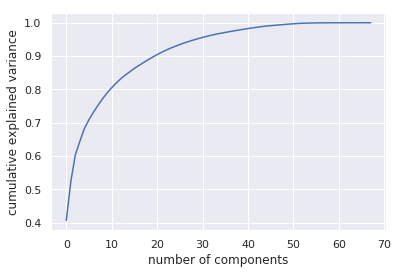

In [33]:
"""
Median imputed
"""
pca = PCA().fit(data.data)
explained = np.cumsum(pca.explained_variance_ratio_)
plt.plot(explained)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [34]:
# Iterate through explained variance until .99 is acheived
for components in range(len(explained)-1):
    if explained[components] >= .99:
        print("{} is the optimal number of components".format(components+1))
        break

46 is the optimal number of components


In [35]:
pca = PCA(n_components=46)
reduced = pca.fit_transform(data.data)

In [44]:
component_matrixes = [pca.components_]

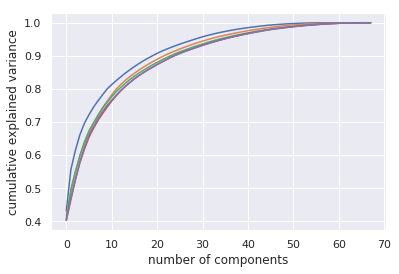

In [48]:
"""
multiple imputed
"""
pca_imputed = []
for frame in data_imputed:
    pca1 = PCA().fit(frame.data)
    explained = np.cumsum(pca1.explained_variance_ratio_)
    plt.plot(explained)
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    
    count = 0
    
    for components in range(len(explained)-1):
        if explained[components] >= .99:
            count = components
            break
            
    r = PCA(n_components=count)
    out = r.fit_transform(frame.data)
    component_matrixes.append(r.components_)
    
    pca_imputed.append(out)

## PCA Save

In [49]:
reduced.dump("../data/production/pca/x_median.pickle")
x_out = ["../data/production/pca/x_imputed_1.pickle",
                "../data/production/pca/x_imputed_2.pickle",
                "../data/production/pca/x_imputed_3.pickle",
                "../data/production/pca/x_imputed_4.pickle",
                "../data/production/pca/x_imputed_5.pickle"]
[pca_imputed[i].dump(x_out[i]) for i in range(5)]

matrixes_files = ["median","1","2","3","4","5"]
for f in range(len(matrixes_files)):
    pd.DataFrame(component_matrixes[f], columns = factors_df.columns).to_csv("../data/production/pca/{}_components.csv".format(matrixes_files[f]))